<a href="https://colab.research.google.com/github/yishanlin22/WiDS-Google-2023/blob/main/wids_datathon_2023_moreChocolate!!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Women in Data Science Hackaton


This notebook is a tutorial for the WiDS Hackathon. In this notebook, we will walk through the end to end process of getting the data, exploring it, feature engineering, modeling, evaluation and submission.

This notebook is only meant to be a starting point. There are multiple areas that we will not cover. When we deal with issues such as data cleaning or model choice, we would only explore 1 or 2 options.

We will use 2 Machine Learning models: a simple linear regression, and gradient boosting trees using the LightGBM implementation.

Other approaches that can be explored are time series methods such as [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)/SARIMAX and deep learning methods for squence modeling and tabular data.
This notebook should be used as a benchmark, upon which you can improve your model.

\
**Reference Links**:

[Registration Form](https://airtable.com/shrSmOC8mMDjc4dFl) for Participating;

[Kaggle Datathon Challenge Page](https://www.kaggle.com/competitions/widsdatathon2023/overview);



### Download Data from Kaggle
1. First, you should log in or sign-up to [Kaggle](https://www.kaggle.com/)
2. Go to "Account"
3. Click on "Create New API Token" under 'API' section
4. Step 3 should trigger the download of the "kaggle.json" credential (likely be sitting in your Downloads/)
5. Upload the "kaggle.json" file to this Colab:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yishanlin22","key":"3137f34af85bc5e565f8106f9aff9060"}'}

In [ ]:
#@title Download the WiDS datasets
#@markdown Make sure your credentials are up-to-date and you have accepted the competition's terms and conditions

# setups
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

! cd content
! kaggle competitions download -c widsdatathon2023
! unzip /content/widsdatathon2023.zip

ref                                                                title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                  8KB  2023-02-01 12:22:51           7525        239  1.0              
amaanansari09/top-100-songs                                        Top 100 songs                                     6KB  2023-02-16 18:55:35           1557         63  1.0              
datascientistanna/customers-dataset                                Shop Customer Data                               23KB  2023-02-07 18:42:21           5981        139  1.0              
thedevastator/airbnb-prices-in-european-cities                   

# Setup

### Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.linear_model import LinearRegression # Linear regression
import lightgbm as lgb # Gradient Boosting Trees

import time

### Load Data

Please find the data dictionary [here](https://www.kaggle.com/competitions/widsdatathon2023/data).

In [ ]:
train_df = pd.read_csv('/content/train_data.csv')
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('/content/test_data.csv')
display(test_df.head().style.set_caption('Test data'))

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

# Exploratory Data Analysis (EDA)

EDA is one of the most important parts of beginning an ML engagement. Understanding the data allows the modelers to find any discrepancies, such as outliers or missing values, and learn the shape and distribution of values. Understanding this is critical for the model's performance and helps inform future feature engineering and design decisions. The main objectives of EDA are:

1. **Examine the data and missing Value Analysis**\
Understand and resolve any potential issues with the data, such as redistributing outliers or imputing missing values.
2. **Univariate Analysis: checking one variable**\
Understand the schema of the available data, which will drive the model's metadata to help during future Continuous Training (CT) cycles to detect potential data skew.
3. **Multivariate Analysis: Checking correlation**\
Inform which type(s) of models will perform best, given the shape of the data, sparsity of features, and relationship between existing fields.

### 1. Examine the data and missing Value Analysis
- Missing value could be caused by mutiple reasons.
- Sometimes missing values could be caused by pulling or delivering mistakes. Examinng the data, especially the missing values can help the modeler to validate the dataset and check with the data provider as early as possible.
- Missing values (either nulls or zeroes) may also be a known scenario in a dataset. Eg. Some questions people choose not to answer in the survey data. The modelers will need to analyze to operate accordingly.
- However, there are times when it was caused by improper data collection and thus affect model performance.

#### Dimensions
Let's look at the data. First, let's see the shape. How many columns and rows we have:

In [ ]:
train_df.shape

(375734, 246)

In [ ]:
train_df.describe

<bound method NDFrame.describe of          index  lat       lon startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
0            0  0.0  0.833333    9/1/14                              237.00   
1            1  0.0  0.833333    9/2/14                              228.90   
2            2  0.0  0.833333    9/3/14                              220.69   
3            3  0.0  0.833333    9/4/14                              225.28   
4            4  0.0  0.833333    9/5/14                              237.24   
...        ...  ...       ...       ...                                 ...   
375729  375729  1.0  0.866667   8/27/16                              312.05   
375730  375730  1.0  0.866667   8/28/16                              305.82   
375731  375731  1.0  0.866667   8/29/16                              311.62   
375732  375732  1.0  0.866667   8/30/16                              304.54   
375733  375733  1.0  0.866667   8/31/16                              295.29   

        nmme0-tmp

In [ ]:
test_df.shape

(31354, 245)

#### Time Range

Let's transform the time feature to datetime check the time range


In [ ]:
# convert to datetime
train_df.startdate = pd.to_datetime(train_df.startdate)
test_df.startdate = pd.to_datetime(test_df.startdate)

In [ ]:
# check data time range
print('Max startdate - train_df:', train_df.startdate.max())
print('Min startdate - train_df:', train_df.startdate.min())

print('Max startdate - test_df:', test_df.startdate.max())
print('Min startdate - test_df:', test_df.startdate.min())

Max startdate - train_df: 2016-08-31 00:00:00
Min startdate - train_df: 2014-09-01 00:00:00
Max startdate - test_df: 2022-12-31 00:00:00
Min startdate - test_df: 2022-11-01 00:00:00


#### Column Types & Missing Values

In [ ]:
train_df.dtypes

index                                          int64
lat                                          float64
lon                                          float64
startdate                             datetime64[ns]
contest-pevpr-sfc-gauss-14d__pevpr           float64
                                           ...      
wind-vwnd-925-2010-16                        float64
wind-vwnd-925-2010-17                        float64
wind-vwnd-925-2010-18                        float64
wind-vwnd-925-2010-19                        float64
wind-vwnd-925-2010-20                        float64
Length: 246, dtype: object

In [ ]:
# does have missing values
print(train_df.isnull().values.any())
print(test_df.isnull().values.any())

True
False


### 2. Univariate Analysis: checking one variable
- For analyzing the data, it's important to go through each feature individually and look at the distribution.
- This includes analyzing common metrics including minimum, maximum, mean, and *frequency*. This can help detect potential outliers that may affect model imperformance.
- After conducting this analysis, you may then engage in data preprocessing to remove any outliers in the data.

#### Continuous Variables
- When dealing with continuous variables, it’s important to know the variable’s central tendency and spread. Statistical metrics visualization methods such as Box-plot, Histogram/Distribution Plot are used to measure this.
- When the continuous variables are time series, it's important to analyze the variables according to time. Plotting over time is usually helpful for the modelers to recgonize the seasonality and the trend.

**Target**\
Target column should be `contest-tmp2m-14d__tmp2m`, which appears in the training data, but it doesn't appear in the test data:

In [ ]:
target = [c for c in train_df.columns if c not in test_df.columns][0]
print(target)

contest-tmp2m-14d__tmp2m


In [ ]:
train_df[target].describe()

count    375734.000000
mean         11.858568
std           9.867901
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238782
Name: contest-tmp2m-14d__tmp2m, dtype: float64

Let's plot the target variable over time:

Text(0.5, 0, 'Date')

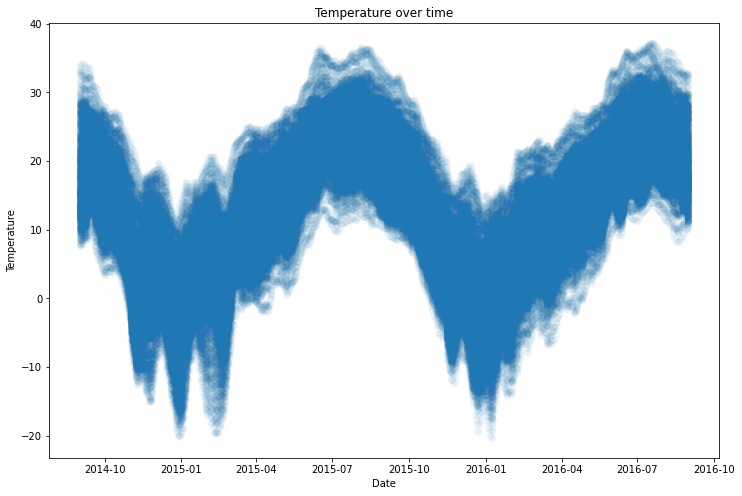

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_df.startdate,
         train_df[target],
         'o',
         alpha=0.03)
plt.title('Temperature over time')
plt.ylabel('Temperature')
plt.xlabel('Date')

Let's also look at the distribution of temperatures:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


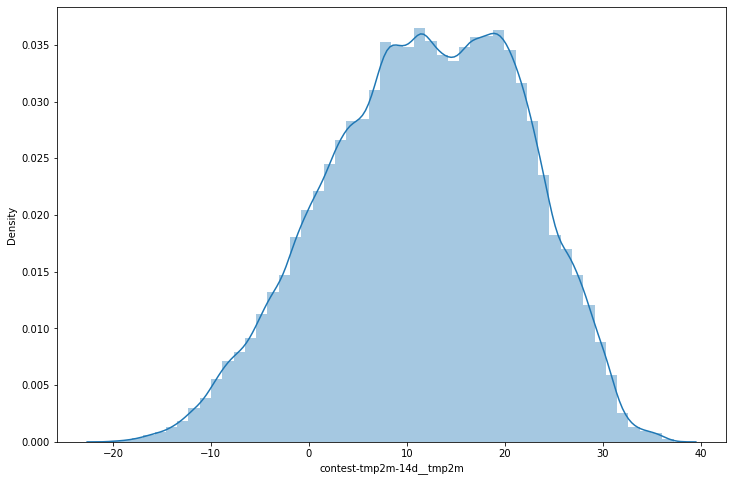

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(train_df[target])

#### Categorical Variables
We’ll utilize a frequency table to study the distribution of categorical variables. Count and Count percent against each category are two metrics that can be used to assess it. As a visualization, a count-plot or a bar chart can be employed.

Let's look at our categorical features:

In [ ]:
train_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')],
      dtype=object)

In [ ]:
train_df.dtypes.sort_values()

index                                    int64
mei__nip                                 int64
mei__meirank                             int64
mjo1d__phase                             int64
sst-2010-2                             float64
                                        ...   
contest-wind-h500-14d__wind-hgt-500    float64
cancm30                                float64
nmme-tmp2m-34w__cfsv2                  float64
wind-vwnd-925-2010-20                  float64
climateregions__climateregion           object
Length: 246, dtype: object

We have only one categorical feature, and that is "climateregions__climateregion"

In [ ]:
train_df.groupby('climateregions__climateregion')['climateregions__climateregion'].size()

climateregions__climateregion
BSh      5117
BSk    139621
BWh      9503
BWk     13889
Cfa     51901
Cfb      4386
Csa      9503
Csb     40936
Dfa     22661
Dfb     52632
Dfc     12427
Dsb      8041
Dsc      2924
Dwa      1462
Dwb       731
Name: climateregions__climateregion, dtype: int64

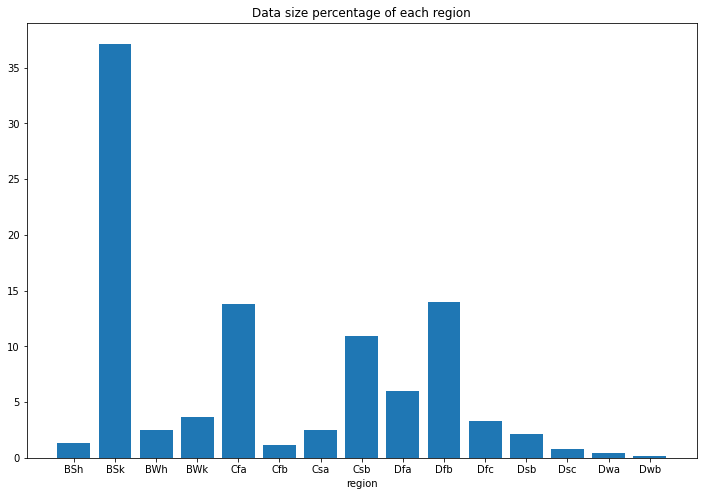

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(x = train_df.groupby('climateregions__climateregion').size().index,
        height = 100 * train_df.groupby('climateregions__climateregion')['climateregions__climateregion'].size() / train_df.shape[0]
        )
plt.title('Data size percentage of each region')
plt.xlabel('region');

### 3. Multivariate Analysis: checking correlation
- Correlation analysis measures the statistical relationship between two different variables. The result will show how the change in one parameter would impact the other parameter.
- Correlation analysis is a very important concept, popular in the field of predictive analytics.
- Though correlation analysis helps us in understanding the association between two variables in a dataset, it can't explain, or measure, the cause.

#### Continuous varibles and target


---


Let's start with a very simple and naive correlation plot and see what features correlate (linearly) with our target variable. We should keep in mind that correlations are a very bsasic tool. They can't capture non-linear relations, and are not ideal for categorical and some raw features (like cooredinates)

In [ ]:
target = 'contest-tmp2m-14d__tmp2m'
train_df.corr()[target].sort_values()

wind-hgt-10-2010-1         -0.815701
wind-vwnd-925-2010-1       -0.807371
wind-hgt-500-2010-1        -0.806078
wind-hgt-100-2010-1        -0.802240
wind-hgt-850-2010-1        -0.779923
                              ...   
nmme-tmp2m-34w__nmmemean    0.950187
nmme-tmp2m-56w__nmmemean    0.950865
nmme-tmp2m-34w__cfsv2       0.954483
nmme-tmp2m-56w__cfsv2       0.954668
contest-tmp2m-14d__tmp2m    1.000000
Name: contest-tmp2m-14d__tmp2m, Length: 244, dtype: float64

We can see that some features are very highly correlated (both negative and positive are very informative). We can use the most informative features for a simple benchmark model

Text(0.5, 0, 'Most correlated feature (nmme-tmp2m-56w__cfsv2)')

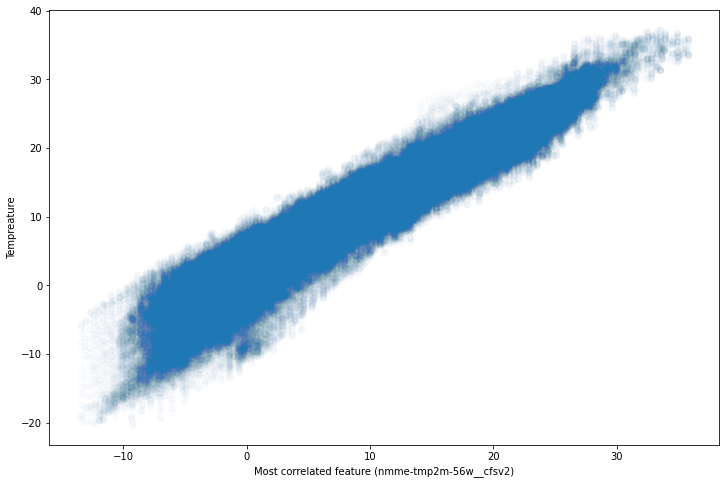

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(train_df['nmme-tmp2m-56w__cfsv2'],
            train_df[target],
            alpha=0.01)
plt.ylabel('Tempreature')
plt.xlabel('Most correlated feature (nmme-tmp2m-56w__cfsv2)')

#### Categonical variables and target


---

Let's check quickly about the mean of the target at each category.

In [ ]:
train_df.groupby('climateregions__climateregion').mean()[target]

climateregions__climateregion
BSh    20.883240
BSk    11.103087
BWh    22.196044
BWk    15.865922
Cfa    17.906166
Cfb    10.832186
Csa    15.686419
Csb    11.523091
Dfa    10.494672
Dfb     6.893599
Dfc     4.406667
Dsb     9.038471
Dsc     7.344342
Dwa     9.741287
Dwb     8.012755
Name: contest-tmp2m-14d__tmp2m, dtype: float64

We can see that the 'climateregions__climateregion' feature is also high informative as the average temperature varies significantly between regions

We have multiple regions, let's create a new feature called "loc_group", based on lat-lon cooredinates:

In [ ]:
train_df['loc_group'] = train_df.groupby(['lat','lon']).ngroup()
train_df['loc_group'].nunique()

514

We have 514 different regions.

Let's plot the temperature for the different location groups:

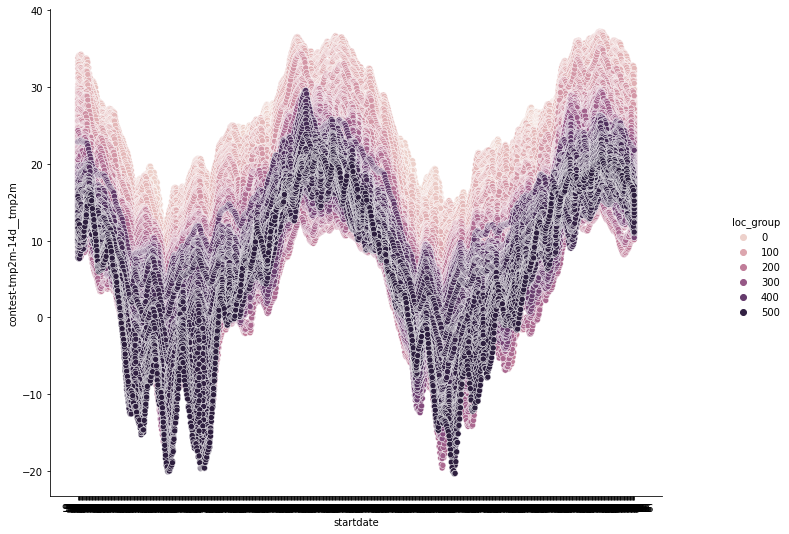

In [ ]:
ax = sns.relplot(data=train_df,
            x='startdate',
            y='contest-tmp2m-14d__tmp2m',
            hue='loc_group')
ax.fig.set_figwidth(12)
ax.fig.set_figheight(8)

#### Continuous variables and Continuous variables


---


1. Observe by visualization(usally scatter plot)
<img src="https://www.mathsisfun.com/data/images/correlation-examples.svg">
2. Correlation coefficient \
<img src="https://vitalflux.com/wp-content/uploads/2020/09/Screenshot-2020-09-29-at-11.19.40-AM.png" width="500">
3. Variance inflation factor(VIF) to flag multicolinearity \
<img src="https://www.reneshbedre.com/assets/posts/reg/multicol.webp?ezimgfmt=ng%3Awebp%2Fngcb2%2Frs%3Adevice%2Frscb2-1" width="600">





# Preprocessing & Feature Engineering

Preprocessing should take into account:
1. Missing and invalid values
2. Categorical values
3. Time Variables

### Missing Values

We have missing values in a few columns. not in our target columns though. We can deal with missing values with a few imperfect ways as below:

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*_RA3mCS30Pr0vUxbp25Yxw.png' width="600">

We will use the very imperfect mean imputation

Let's check for null values in the training *data*:

In [ ]:
train_df.isnull().values.any()

True

In [ ]:
for col in train_df.columns:
    if train_df[col].isnull().values.any():
        print(col, train_df[col].isnull().values.sum())

nmme0-tmp2m-34w__ccsm30 15934
nmme-tmp2m-56w__ccsm3 10280
nmme-prate-34w__ccsm3 8738
nmme0-prate-56w__ccsm30 15934
nmme0-prate-34w__ccsm30 15934
nmme-prate-56w__ccsm3 10280
nmme-tmp2m-34w__ccsm3 8738
ccsm30 15934


In [ ]:
for col in train_df.columns:
    if train_df[col].isnull().values.any():
        train_df[col].fillna(train_df[col].mean(), inplace=True)

### Categorical Variables

Next we will deal with the categorical feature. Below are some common encoding techniques to convert catgoricalvariables into numerical values.

<img src="https://ai-ml-analytics.com/wp-content/uploads/2021/02/Encoding-1.png">

We only have one categorical feature. We can encode it in several ways:
1. One-hot encoding - turn the feature into 15 binary columns (because there are 15 distinct values) where the "hot" value is 1 and all the others are 0. That's a very good method when there is a small number of unique values, an gets worse the more unique values we have. What is "large" heavily depends on the data distribution and amount of information stored in the categorical feature. 15 is somewhat borderline.
2. Label-encoding - replace the categorical value with an integer index. This does not increase the dimensionality of the data (we don't have 15 new columns now). However, the integer index is somewhat arbitrary and it implies relations between the categories that are not necessarily true.
3. Target-encoding - replace the categorical value with the average target value for this category. This method is very good but has the risk of overfitting.




Below is an example to use LabelEncoder to transform a categorical variable:

In [ ]:
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])

In tabular problems, feature engineering is often the most important part. In feature engineering we create new features that capture the relationship between the target variable and our features best, based on our domain knowledge or from the EDA.

In [ ]:
train_df.climateregions__climateregion.unique()

array([ 0,  4,  1,  3,  2,  6,  7,  5,  9, 12, 10,  8, 11, 13, 14])

### Time Features
1. dummy variables
2. (optional) cyclical encoding with sine/cosine transformation

In [ ]:
# extract year, month, day of year
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['year'] = df.startdate.dt.year
    df['month'] = df.startdate.dt.month
    df['dayofyear'] = train_df.startdate.dt.day_of_year
    return df

train_df = create_time_features(train_df)
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group,year,month,dayofyear
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-2.03,48.13,28.09,-13.50,11.90,4.58,0,2014,9,244
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,4.44,48.60,27.41,-23.77,15.44,3.42,0,2014,9,245
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,5.01,48.53,19.21,-33.16,15.11,4.82,0,2014,9,246
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-1.41,50.59,8.29,-37.22,18.24,9.74,0,2014,9,247
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-5.21,54.73,-2.58,-42.30,21.91,10.95,0,2014,9,248


In [ ]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7
def add_season(df: pd.DataFrame) -> None:
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2,
      9: 3,
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(train_df)

(Optional) Since time is cyclical, let's add features that express the seasonality and cyclicalness of our data (that's a common transformation for time features):

In [ ]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    # encode the season with a period of 4
    df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(train_df)

In [ ]:
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,year,month,dayofyear,season,day_of_year_sin,day_of_year_cos,month_sin,month_cos,season_sin,season_cos
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,2014,9,244,3,-0.871706,-0.490029,-1.0,-1.836970e-16,-1.0,-1.836970e-16
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,2014,9,245,3,-0.880012,-0.474951,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,2014,9,246,3,-0.888057,-0.459733,-1.0,-1.836970e-16,-1.0,-1.836970e-16
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,2014,9,247,3,-0.895839,-0.444378,-1.0,-1.836970e-16,-1.0,-1.836970e-16
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,2014,9,248,3,-0.903356,-0.428892,-1.0,-1.836970e-16,-1.0,-1.836970e-16


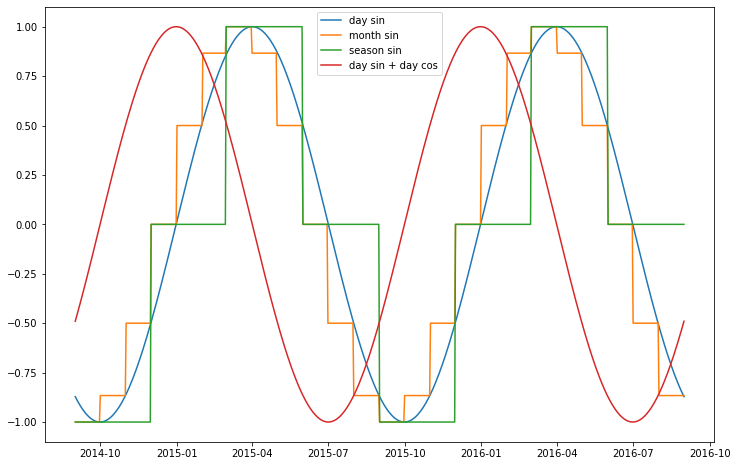

In [ ]:
cyc_df_eg = train_df[train_df.loc_group == 3]
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(cyc_df_eg.startdate, cyc_df_eg['day_of_year_sin'], label='day sin')
ax.plot(cyc_df_eg.startdate, cyc_df_eg['month_sin'], label='month sin')
ax.plot(cyc_df_eg.startdate, cyc_df_eg['season_sin'], label='season sin')
ax.plot(cyc_df_eg.startdate, (cyc_df_eg['day_of_year_cos'] + cyc_df_eg['day_of_year_cos'])/2,
        label='day sin + day cos')
plt.legend()

# Modeling
We will use 2 models:
1. Linear Regression
2. Lightgbm


### Train - Validate Split

feature selection


In [ ]:
exclude_cols = ['index', 'startdate']
features = [c for c in train_df.columns if ((c != target) & (c not in exclude_cols))]


# train_df.sort_values(by='startdate', inplace=True) # Verify the data is sorted by time
# train_df.reset_index(inplace=True)
split_point = 0.98 # 98 % training, 2% validation, because we have a lot of data, 2% validation can be enough
train = train_df[:int(split_point*len(train_df))]
val  = train_df[int(split_point*len(train_df)):]

# Altenative - split by time:
# train = train_df[train_df['startdate'] <= '2016-08-17']
# val  = train_df[train_df['startdate'] > '2016-08-17']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

## Linear Model

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

##  Evaluation

When we evaluate our model we need to choose the right metric. The right metric would fit the data distribution as well as the final business KPI we actually care about.

This is a regression model, and therefore we should choose an evaluation metric for a regression problem.
There are a few possiblities:
1. [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
2. [R2](https://en.wikipedia.org/wiki/Coefficient_of_determination)
3. [Mean Absolotue Error](https://en.wikipedia.org/wiki/Mean_absolute_error)

And others.

In [ ]:
print(f'Training RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False)}')
print(f'Validation RMSE: {mean_squared_error(y_val, model.predict(X_val), squared=False)}')

Training RMSE: 1.3076930717252842
Validation RMSE: 1.6243012405089148


Text(0.5, 1.0, 'Validation RMSE for Linear model is 1.6093728636191855')

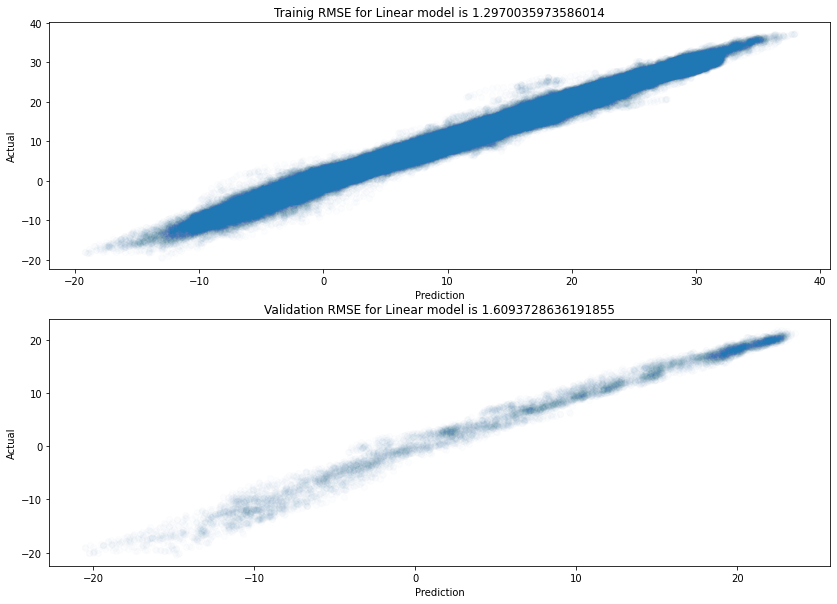

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.scatter(model.predict(X_train), y_train, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Trainig RMSE for Linear model is {mean_squared_error(y_train, model.predict(X_train), squared=False)}')

plt.subplot(212)
plt.scatter(model.predict(X_val), y_val, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Validation RMSE for Linear model is {mean_squared_error(y_val, model.predict(X_val), squared=False)}')

##  LightGBM
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

[XGBoost vs. LightGBM](https://neptune.ai/blog/xgboost-vs-lightgbm)



In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 5
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval)

Starting training...
[1]	valid_0's l1: 9.88669	valid_0's l2: 156.512
[2]	valid_0's l1: 9.43162	valid_0's l2: 143.153
[3]	valid_0's l1: 9.01627	valid_0's l2: 131.313
[4]	valid_0's l1: 8.60531	valid_0's l2: 120.185
[5]	valid_0's l1: 8.21783	valid_0's l2: 110.277
[6]	valid_0's l1: 7.8652	valid_0's l2: 101.788
[7]	valid_0's l1: 7.51135	valid_0's l2: 93.4403
[8]	valid_0's l1: 7.18524	valid_0's l2: 85.7566
[9]	valid_0's l1: 6.87571	valid_0's l2: 79.0017
[10]	valid_0's l1: 6.57335	valid_0's l2: 72.6945
[11]	valid_0's l1: 6.2933	valid_0's l2: 67.3499
[12]	valid_0's l1: 6.01472	valid_0's l2: 61.8841
[13]	valid_0's l1: 5.74346	valid_0's l2: 56.8498
[14]	valid_0's l1: 5.50386	valid_0's l2: 52.4381
[15]	valid_0's l1: 5.27135	valid_0's l2: 48.5334
[16]	valid_0's l1: 5.05955	valid_0's l2: 45.1374
[17]	valid_0's l1: 4.84492	valid_0's l2: 41.579
[18]	valid_0's l1: 4.64634	valid_0's l2: 38.728
[19]	valid_0's l1: 4.45241	valid_0's l2: 35.8896
[20]	valid_0's l1: 4.28517	valid_0's l2: 33.4893
[21]	valid_0

In [ ]:
print(f'Training RMSE: {mean_squared_error(y_train, gbm.predict(X_train), squared=False)}')
print(f'Validation RMSE: {mean_squared_error(y_val, gbm.predict(X_val), squared=False)}')

Training RMSE: 0.8523526381088952
Validation RMSE: 1.115236690292167


Text(0.5, 1.0, 'Validation RMSE for LightGBM model is 1.115236690292167')

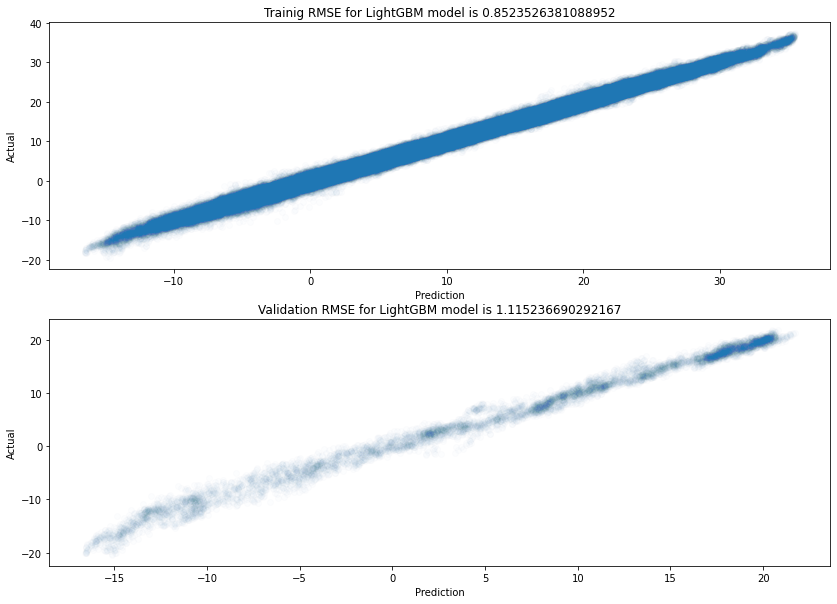

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.scatter(gbm.predict(X_train), y_train, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Trainig RMSE for LightGBM model is {mean_squared_error(y_train, gbm.predict(X_train), squared=False)}')

plt.subplot(212)
plt.scatter(gbm.predict(X_val), y_val, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Validation RMSE for LightGBM model is {mean_squared_error(y_val, gbm.predict(X_val), squared=False)}')

# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

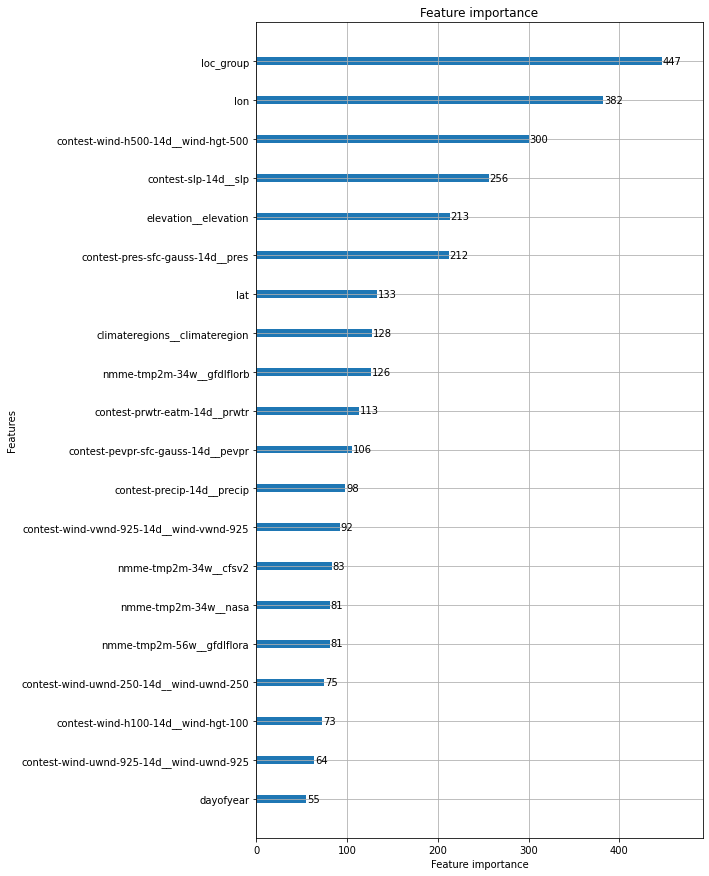

In [ ]:
lgb.plot_importance(gbm, max_num_features=20, figsize=(8,15))

# Hyperparameter Tuning
Hyperparameters are parameters that are not learned from the data. Each model has different hyperparameters. For a linear regression this can be the strength of the regularization parameter. For tree based models such as gradient boosting trees this can constraints on the tree structure such as maximal depth, minimal number of samples per leaf, number of trees, etc.

Many times the hyperparameters are used to optimize the trade-off between fitting the training data and generalization (in other words, the bias-variance or the underiftting-overfitting trade-off/problem).

Hyperoarameters tuning can be done automatically with grid-search, Bayesian optimization or any other kind of way to sample and optimize the space of hyperparameters. However, when we do that we should be careful not to overfit to our validation set. We should also take into account that searching over this multi-dimensional space of possible values may take a lot of time

We will try to tweek some of the lightGBM model hyperparameters.

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 120,
    'learning_rate': 0.03,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 5,
    'max_depth': 7
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=400,
                valid_sets=lgb_eval,
                callbacks = [lgb.early_stopping(stopping_rounds = 30)])

Starting training...
[1]	valid_0's l1: 10.0616	valid_0's l2: 162.055
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 9.77814	valid_0's l2: 153.309
[3]	valid_0's l1: 9.50288	valid_0's l2: 145.088
[4]	valid_0's l1: 9.23909	valid_0's l2: 137.371
[5]	valid_0's l1: 8.98214	valid_0's l2: 129.999
[6]	valid_0's l1: 8.74141	valid_0's l2: 123.452
[7]	valid_0's l1: 8.49468	valid_0's l2: 116.85
[8]	valid_0's l1: 8.26356	valid_0's l2: 110.799
[9]	valid_0's l1: 8.0479	valid_0's l2: 105.327
[10]	valid_0's l1: 7.83373	valid_0's l2: 100.042
[11]	valid_0's l1: 7.61831	valid_0's l2: 94.8733
[12]	valid_0's l1: 7.40887	valid_0's l2: 89.8818
[13]	valid_0's l1: 7.19987	valid_0's l2: 85.0652
[14]	valid_0's l1: 7.00103	valid_0's l2: 80.6846
[15]	valid_0's l1: 6.80844	valid_0's l2: 76.457
[16]	valid_0's l1: 6.62852	valid_0's l2: 72.594
[17]	valid_0's l1: 6.45228	valid_0's l2: 68.9798
[18]	valid_0's l1: 6.28391	valid_0's l2: 65.5962
[19]	valid_0's l1: 6.11483	valid_0's l2: 62.3252

In [ ]:
print(f'Training RMSE: {mean_squared_error(y_train, gbm.predict(X_train), squared=False)}')
print(f'Validation RMSE: {mean_squared_error(y_val, gbm.predict(X_val), squared=False)}')

Training RMSE: 0.605453294060644
Validation RMSE: 0.930183868142486


Text(0.5, 1.0, 'Validation RMSE for LightGBM model is 0.9093701320956344')

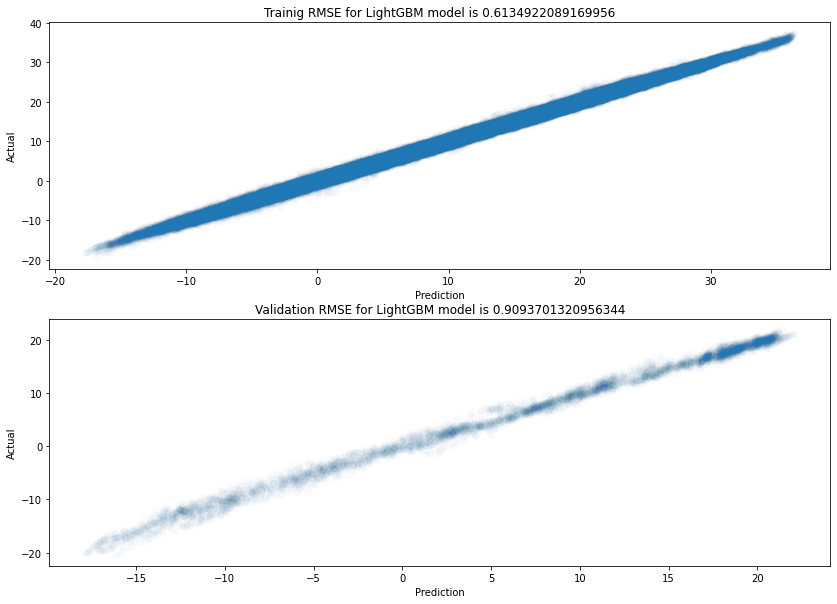

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.scatter(gbm.predict(X_train), y_train, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Trainig RMSE for LightGBM model is {mean_squared_error(y_train, gbm.predict(X_train), squared=False)}')

plt.subplot(212)
plt.scatter(gbm.predict(X_val), y_val, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Validation RMSE for LightGBM model is {mean_squared_error(y_val, gbm.predict(X_val), squared=False)}')

Automate Hyperparameters Optimization

# Submission

Before submission we need to transform the test dataset using the same transofmrations we used for the training dataset, *but use only transformations and data from the training dataset, to avoid overfitting*

Deal with missing values. Notice that we use the training dataset values to avoid overfitting (since the test data is actually available one might argue that it is OK to use them. And maybe for the sake of competition it's worth trying using the test dataset values for missing values imputation. But in general this os not a good practice):

In [ ]:
for col in test_df.columns:
    if test_df[col].isnull().values.any():
        test_df[col].fillna(train_df[col].mean(), inplace=True)

Categorical data. Here we also have to use the label encoder trained on the training data:

In [ ]:
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])

Text Features:

In [ ]:
test_df = create_time_features(test_df)

add_season(test_df)
encode_cyclical(test_df)

Encode log group based on loc groups of training data

In [ ]:
temp = train_df.groupby(['lat','lon']).mean()['loc_group'].reset_index()
regions_dict = dict()
for row in temp.iterrows():
  key = str(row[1].lat) + '_' + str(row[1].lon)
  regions_dict[key] = row[1].loc_group

test_df['regions_key'] = test_df.apply(lambda x: str(x.lat) + '_' + str(x.lon),
                                       axis=1)
test_df['loc_group'] = test_df.regions_key.apply(lambda x: regions_dict.get(x, -1))

In [ ]:
submission = pd.read_csv('sample_solution.csv')
display(submission)
submission[target] = gbm.predict(test_df[features])

submission.to_csv('submission.csv',
                   index = False) # Set index to false to avoid issues in evaluation

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738
...,...,...
31349,28.303967,407083
31350,26.635933,407084
31351,27.057762,407085
31352,26.871066,407086


In [ ]:
a = pd.read_csv("submission.csv")

In [ ]:
a

,contest-tmp2m-14d__tmp2m,index
0,29.360469,375734
1,29.337910,375735
2,29.372871,375736
3,29.369386,375737
4,29.381917,375738
...,...,...
31349,3.859560,407083
31350,3.784080,407084
31351,3.053984,407085
31352,2.744386,407086


Upload this file to the competition page. This submission should give a RMSE 
of 1.41. which as of January 29th would put you in the 146th place :)

# Next Steps
Ways you can consider in order to improve your prediction:

#### Explore different modeling strategies
- **Time Series** models such as SARIMAX (which takes into account both seasonality and exogenous variables)
- **Different ML models**: You can try neaural networks. Look for either networks for tabular data (such as TabNet and TabTransformer) or neural networks for squence modeling (like RNNs, LSTM and transformer-based models)
- **Ensambling** different models to obtain a weighted average prediction

#### Improve data prepocessing and feature engineering
- Change the categorical features representation to one-hot encoding, target encoding or embedding (you can also use other models that are designed to work with categorical features such as CatBoost)
- Change the missing values strategy. For example, denote the missing values with a special value, or try to predict the missing value based on other features
- Think of new features that you can engineer from the existing features that would better represent the data using your knowledge of the problem
- Try splitting the train-validation data based on a different logic (such as seasons)

#### Hyperparameter Tuning
- Try tweaking different hyperparameters
- Grid search with more granularity

# References
- [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)
- [Different types of Encoding](https://ai-ml-analytics.com/encoding/)
- [Three Approaches to Encoding Time Information as Features for ML Models](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
- [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/)
- [XGBoost vs LightGBM: How Are They Different](https://neptune.ai/blog/xgboost-vs-lightgbm)
